In [1]:
from IPython.display import display

from io import StringIO
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import scipy
import statsmodels.sandbox.distributions.extras as smde
import os
import pandas as pd

sns.set_style("whitegrid")


In [2]:
supply = pd.read_csv('20201007_da_co.processed.csv').set_index('id')
nsupply = len(supply)
print(supply.shape)
supply.head()

(2851, 3)


,node,capacity (MW),offer ($/MW)
id,,,
A3153_0,North,1.0,8.16
A3153_1,North,245.0,9.54
A3153_2,North,1.0,14.27
A3153_3,North,72.0,14.28
A3167_0,Central,330.0,8.74


In [3]:
nodes = supply.node.unique()

In [4]:
supply['type'] = np.where(supply['offer ($/MW)'] <= 0, 'wind', 'inflexible')

non_zero_offers = supply.loc[supply['offer ($/MW)'] > 0]
flexible_threshold = non_zero_offers['offer ($/MW)'].quantile(0.75)
supply.loc[supply['offer ($/MW)'] >= flexible_threshold, 'type'] = 'flexible'

supply.groupby('type')['capacity (MW)'].agg([np.sum, len])

,sum,len
type,,
flexible,10682.7,647.0
inflexible,97074.5,1941.0
wind,38076.0,263.0


In [5]:
supply.groupby(['node', 'type'])['capacity (MW)'].agg([np.sum, len])

sum    len
node    type                      
Central flexible     7856.5  324.0
        inflexible  44940.7  896.0
        wind        13666.6   64.0
North   flexible     1979.1  254.0
        inflexible  17551.3  572.0
        wind        24364.4  198.0
South   flexible      847.1   69.0
        inflexible  34582.5  473.0
        wind           45.0    1.0

In [6]:
supply.to_csv('20201007_da_co.classified.csv')

In [7]:
wind_supply = supply.loc[supply['type'] == 'wind']
wind_capacity = wind_supply['capacity (MW)']
HISTORICAL_WIND = 11937.76
wind_scaler = HISTORICAL_WIND / wind_capacity.sum()
base_scenario = pd.DataFrame({
    'scenario': 0, 
    'id': wind_supply.index,
    'actual (MW)': wind_capacity * wind_scaler,
}).reset_index(drop=True)
base_scenario.head()

,scenario,id,actual (MW)
0,0,A3200,62.704906
1,0,A3205,0.627049
2,0,A3213,13.481555
3,0,A3215,62.704906
4,0,A3375,62.704906


In [8]:
mu, sigma, skew, kurt = 0.0117, 0.1187, -0.616, 1.0308
sd_wide = 10
f = smde.pdf_mvsk([mu, sigma**2, skew, kurt])
x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=1000)
y = [f(i) for i in x]
yy = np.cumsum(y) / np.sum(y)
error_inv_cdf = scipy.interpolate.interp1d(yy, x, fill_value="extrapolate")

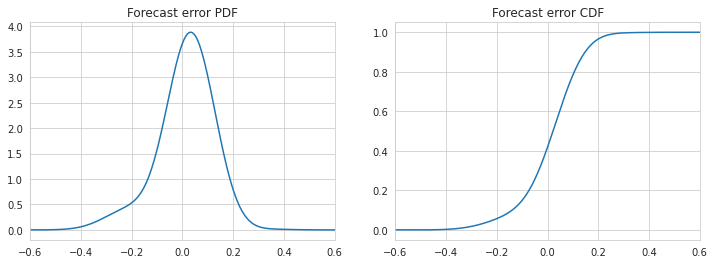

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True)
axs[0].plot(x, y)
axs[0].set_title('Forecast error PDF')
axs[1].plot(x, yy)
axs[1].set_title('Forecast error CDF')
plt.xlim(-0.6, 0.6);

In [10]:
region_alpha = 0.9
random_seed = 31792
rng = np.random.default_rng(seed=random_seed)
n_scenarios = 99

scenarios = []
for i in range(1, n_scenarios+1):
    node_rv = dict(zip(nodes, rng.random(3)))
    scenario = base_scenario.copy()
    gen_rv = (
        region_alpha * supply.loc[scenario['id'], 'node'].apply(node_rv.get) 
        + (1 - region_alpha) * rng.random(len(scenario))
    )
    scenario['actual (MW)'] *= (1 + error_inv_cdf(gen_rv))
    scenario['scenario'] = i
    scenarios.append(scenario)

In [11]:
all_scenarios = pd.concat([base_scenario] + scenarios, axis=0)
all_scenarios.to_csv('20201007_da_co.scenarios.csv', index=False)